In [1]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd '/content/gdrive/MyDrive/CSE 527 CV/Chauhan_JugalDeepak_115059432_hw5'

/content/gdrive/MyDrive/CSE 527 CV/Chauhan_JugalDeepak_115059432_hw5


### Part 1 Load dataset
---

We'll train a model to generate pictures of facades from label maps, using the [CMP Facade
Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) . This dataset contains 606 rectified images of facades from various sources, which have been manually annotated.

**{10 points}** For the training process, we will use a batch size equal to `1`, as in the original paper. During testing, we will process `4` images in a single batch, so that we can visualize
several results at once.

Load the training set and test set under the folder `./facades`. Normalize the images to $[-1, 1]$. For each set, return a batch list. Show one image from the training set and its label side by side in a `1x2` grid.

In [3]:
# download the dataset
! chmod +x ./download_dataset.sh
! ./download_dataset.sh

for details.

--2022-12-05 04:06:27--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M   769KB/s    in 66s     

2022-12-05 04:07:33 (449 KB/s) - ‘facades.tar.gz’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/test/17.jpg
facades/test/18.j

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import imageio

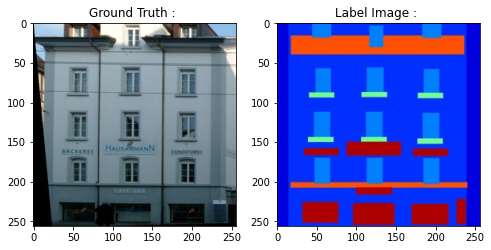

In [5]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def load_dataset(path, shuffle=False):
    imgn = [n for n in glob.glob(path + '/*.jpg')]
    data = []
    ##########--WRITE YOUR CODE HERE--##########
    for i in imgn:
        img = imageio.imread(i)
        h, w, d = img.shape     
        w = w//2
        sl  = img[:, :w, :]
        sr = img[:, w:, :]
        t = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
        sl, sr = t(sl), t(sr)
        data.append((sr,sl)) 
    ##########-------END OF CODE-------##########
    return data


set_seeds(302)
train = load_dataset('./facades/train', shuffle=True)
test = load_dataset('./facades/test')


def showimg(sl, sr):
    ##########--WRITE YOUR CODE HERE--##########
    sl, sr = ((sl +1)*127.5)/255, ((sr +1)*127.5)/255
    sl, sr  = sl.numpy(), sr.numpy()
    sl, sr = sl.transpose(1,2,0), sr.transpose(1,2,0)
    f, a = plt.subplots(1, 2 , figsize=(8,4))
    a[0].imshow(sr)
    a[0].set_title("Ground Truth : ")
    a[1].imshow(sl)
    a[1].set_title("Label Image : ")
    ##########-------END OF CODE-------##########    
    
    
idx = 150
showimg(train[idx][0], train[idx][1])

In [6]:
train[idx][0].shape

torch.Size([3, 256, 256])

In [7]:
import tensorflow as tf
output = tf.concat(train[idx],0)
output.shape

TensorShape([6, 256, 256])

In [8]:
output.dtype

tf.float32

### Part 2 Models
---
In this part, we will define the network based on the architectures from the paper.
Please check the Appendix of the paper for the details of this architecture.

Let $Ck$ denote a Convolution-BatchNorm-ReLU layer with k filters. $CDk$
denotes a Convolution-BatchNormDropout-ReLU layer with a dropout rate of 50%. All
convolutions are 4 x 4 spatial filters applied with stride 2. Convolutions in the encoder,
and in the discriminator, downsample the input by a factor of 2, whereas in the decoder
they upsample the input by a factor of 2.

#### **{15 points}** (a) Generator
The U-Net encoder-decoder architecture consists of:

U-Net encoder:
$$C64-C128-C256-C512-C512-C512-C512-C512$$

U-Net decoder:

$$CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128$$

After the last layer in the decoder, a convolution is applied to map to the number
of output channels, which is `3` in our problem, followed by a `tanh` function. As a
special case, batch normalization is not applied to the first $C64$ layer in the encoder.
All ReLUs in the encoder are leaky, with slope `0.2`, while ReLUs in the decoder are
not leaky.
If you are not familiar with the architecture of UNet, please check [this paper](https://arxiv.org/abs/1505.04597) first.

#### **{15 points}** (b) Discriminator

The discriminator architecture is:
$$C64-C128-C256-C512$$
After the last layer, a convolution is applied to map to a 1-dimensional output,
followed by a sigmoid function. As an exception to the above notation, batch
normalization is not applied to the first $C64$ layer. All ReLUs are leaky, with slope
`0.2`.

Hint: Use `torch.nn.functional.leaky_ReLU` for leaky ReLU.

In [9]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channels):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(n_channels*2, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 1)

        
    def forward(self, x):

        x = torch.cat([x[0], x[1]], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x_d = F.sigmoid(self.conv5(x))        

        return x_d

  
# netD = # initialize the discriminator
netD = Discriminator(3)
# feel free to do some sanity check here
  

In [10]:
class GeneratorUNet(nn.Module):
    def __init__(self, n_channels):
        super(GeneratorUNet, self).__init__()
        # encode : 𝐶64 − 𝐶128 − 𝐶256 − 𝐶512 − 𝐶512 − 𝐶512 − 𝐶512 − 𝐶512
        self.conv1 = nn.Conv2d(n_channels, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 512, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, 4, 2, 1)
        
        # decoder : 𝐶𝐷512 − 𝐶𝐷1024 − 𝐶𝐷1024 − 𝐶1024 − 𝐶1024 − 𝐶512 − 𝐶256 − 𝐶128
        self.deconv1 = nn.ConvTranspose2d(512, 512, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(512)
        self.deconv4 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(512)
        self.deconv5 = nn.ConvTranspose2d(1024, 256, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(256)
        self.deconv6 = nn.ConvTranspose2d(512, 128, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(128)
        self.deconv7 = nn.ConvTranspose2d(256, 64, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(64)
        self.deconv8 = nn.ConvTranspose2d(128, 3, 4, 2, 1)        
    
    def forward(self, x):   
        e1 = self.conv1(x)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))

        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        x_g = F.tanh(d8)
        return x_g
  
# netG = # initialize the discriminator
netG = GeneratorUNet(3)
netGL1 = GeneratorUNet(3)
# feel free to do some sanity check here

In [11]:
from torch.autograd import Variable

In [12]:
train[idx][0].dtype

torch.float32

In [13]:
inx = Variable(train[idx][1].reshape(1,3,256,256)).float()

In [14]:
inx.shape

torch.Size([1, 3, 256, 256])

In [15]:
op = netG(torch.randn((1, 3, 256, 256)))

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


### Part 3 Optimizor
---
**{5 points}** For optimization, we'll use the Adam optimizer, with a learning rate of `0.0002`, and momentum parameters  $\beta_1= 0.5$; $\beta_2 = 0.999$.

In [16]:
# Define the optimizors here, make sure you give them the right parameters

og = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
od = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
ogl1 = optim.Adam(netGL1.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Part 4 Training
---
**{20 points}** For each batch, first train discriminator D by using the average loss of real image and fake image. Then train generator G by using the following loss equation.
$$G^*=\arg \min_{G} \max_{D} L_{cGAN}(G, D) + \lambda L_{L1}(G) $$

In this homework, you will train two different models: one using only the L1 loss, the other using the equation above with $\lambda = 100$. 

As a sanity check, please compare your results with those in the paper (e.g. Figure 4) to make sure they roughly match.

Train the network for at least 20 epochs (at least 10 epochs for the model with only L1 loss,) but you are encouraged to train longer to obtain better results. (In the paper, they train
for 200 epochs.) Save your models to `pix2pix.pth` and `pix2pixL1.pth` using the given code. 

Note: Training training each epoch should take less than 2 minutes if you are using Colab. **Remember to save your models regularly** so you won't lose your progress accidentally.

**{5 points}** In the end, plot the Generator/Discriminator (G/D) loss history (averaged per epoch) of the two models with respect to the epoch in two plots. i.e. the first plot should contain the G/D loss of the model with L1 and cGAN, the second plot should contain the L1 loss of the other model.


In [17]:
from torchvision.utils import save_image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = netG.to(device)
netD = netD.to(device)
netG.train()
netD.train()

# loading images via data loader
from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image

def load_image(file):
    img = PIL.Image.open(file)
    imgb = img.crop((0,0,256,256))
    imga = img.crop((256,0,512,256))
    t = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    return t(imga), t(imgb)

class dataset(Dataset):
    def __init__(self, mode):
        self.files = glob.glob('%s/%s/*'%('facades', mode))
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        a, b = load_image(self.files[idx])
        return a, b

train_loader = DataLoader(dataset("train"), 1, shuffle=True)

def train_model(netG, netD, og, od, train_loader, epoch):
    G_loss, D_loss = [], []
    ganl = F.binary_cross_entropy_with_logits
    for i, (a, b) in enumerate(train_loader):
        a, b = a.to(device), b.to(device)
        real_image, fake_image = torch.ones((a.size(0), 1, 30, 30)).to(device) , torch.zeros((a.size(0), 1, 30, 30)).to(device)
        og.zero_grad()
        fake_image_b = netG(a)
        pred = netD((a, fake_image_b))
        loss_G = ganl(pred, real_image) + F.l1_loss(b, fake_image_b) * 100
        loss_G.backward()
        og.step()
        od.zero_grad()
        pred_real_image, pred_fake_image= netD((a, b)), netD((a, fake_image_b.detach()))
        loss_real_image, loss_fake_image = ganl(pred_real_image, real_image), ganl(pred_fake_image, fake_image)
        loss_D = (loss_real_image + loss_fake_image) * 0.5
        loss_D.backward()
        od.step()
        G_loss.append(loss_G.item())
        D_loss.append(loss_D.item())
        if (i+1) % 10 == 0:
            g_mean, d_mean = np.mean(G_loss[-10:]), np.mean(D_loss[-10:])
            print("\rEpoch %d /// Processed %d/%d /// G loss: %f /// D loss: %f" %
                    (epoch, i, len(train_loader), g_mean, d_mean))
    return np.mean(G_loss), np.mean(D_loss)

epochs = 30
G_losses = []
D_losses =[]
for epoch in range(epochs):
        G_loss, D_loss = train_model(netG, netD, og, od, train_loader, epoch)
        print('\nG Loss = %.4f /// D Loss = %.4f /// G/D Loss = %.4f\n'%(G_loss, D_loss, G_loss/D_loss))
        G_losses.append(G_loss)
        D_losses.append(D_loss)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 /// Processed 9/400 /// G loss: 57.645918 /// D loss: 0.684435
Epoch 0 /// Processed 19/400 /// G loss: 46.100754 /// D loss: 0.626425
Epoch 0 /// Processed 29/400 /// G loss: 42.706703 /// D loss: 0.634316
Epoch 0 /// Processed 39/400 /// G loss: 40.839693 /// D loss: 0.626090
Epoch 0 /// Processed 49/400 /// G loss: 39.878388 /// D loss: 0.638483
Epoch 0 /// Processed 59/400 /// G loss: 39.427523 /// D loss: 0.659683
Epoch 0 /// Processed 69/400 /// G loss: 37.850913 /// D loss: 0.667080
Epoch 0 /// Processed 79/400 /// G loss: 36.485452 /// D loss: 0.647985
Epoch 0 /// Processed 89/400 /// G loss: 39.483366 /// D loss: 0.634654
Epoch 0 /// Processed 99/400 /// G loss: 40.099183 /// D loss: 0.606771
Epoch 0 /// Processed 109/400 /// G loss: 39.630662 /// D loss: 0.624318
Epoch 0 /// Processed 119/400 /// G loss: 36.125128 /// D loss: 0.637862
Epoch 0 /// Processed 129/400 /// G loss: 40.473055 /// D loss: 0.616690
Epoch 0 /// Processed 139/400 /// G loss: 37.546172 /// D loss

In [18]:
netGL1 = netGL1.to(device)
netGL1.train()

##########--WRITE YOUR CODE HERE--########## 
def train_model(netGL1, og, train_loader, epoch):

    GL1_loss = []

    for i, (a, b) in enumerate(train_loader):
        a, b = a.to(device), b.to(device)
        real , fake= torch.ones((a.size(0), 1, 30, 30)).to(device), torch.zeros((a.size(0), 1, 30, 30)).to(device)
        og.zero_grad()
        fake_b = netGL1(a)
        loss_G = F.l1_loss(b, fake_b)
        loss_G.backward()
        ogl1.step()
        GL1_loss.append(loss_G.item())

        if (i+1) % 10 == 0:
            g_mean = np.mean(GL1_loss[-10:])
            print("\rEpoch %d /// Processed %d/%d /// GL1 loss = %f" %
                    (epoch, i, len(train_loader), g_mean))

        iters = epoch * len(train_loader) + i

    return np.mean(GL1_loss)

epoch_l1 = 30
GL1_losses = []
for epoch in range(epoch_l1):
        GL1_loss = train_model(netGL1, og, train_loader, epoch)
        print('\nGL1_loss = %.4f \n'%(GL1_loss))
        GL1_losses.append(GL1_loss)
##########-------END OF CODE-------##########

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0 /// Processed 9/400 /// GL1 loss = 0.563763
Epoch 0 /// Processed 19/400 /// GL1 loss = 0.475295
Epoch 0 /// Processed 29/400 /// GL1 loss = 0.493140
Epoch 0 /// Processed 39/400 /// GL1 loss = 0.476406
Epoch 0 /// Processed 49/400 /// GL1 loss = 0.431209
Epoch 0 /// Processed 59/400 /// GL1 loss = 0.430513
Epoch 0 /// Processed 69/400 /// GL1 loss = 0.429340
Epoch 0 /// Processed 79/400 /// GL1 loss = 0.407309
Epoch 0 /// Processed 89/400 /// GL1 loss = 0.417569
Epoch 0 /// Processed 99/400 /// GL1 loss = 0.419892
Epoch 0 /// Processed 109/400 /// GL1 loss = 0.422702
Epoch 0 /// Processed 119/400 /// GL1 loss = 0.460450
Epoch 0 /// Processed 129/400 /// GL1 loss = 0.412464
Epoch 0 /// Processed 139/400 /// GL1 loss = 0.454854
Epoch 0 /// Processed 149/400 /// GL1 loss = 0.398627
Epoch 0 /// Processed 159/400 /// GL1 loss = 0.476083
Epoch 0 /// Processed 169/400 /// GL1 loss = 0.413022
Epoch 0 /// Processed 179/400 /// GL1 loss = 0.455121
Epoch 0 /// Processed 189/400 /// GL1 l

In [19]:
# codes for saving models, feel free to change them

torch.save({
    'G': netG.state_dict(),
    'D': netD.state_dict(),
    'epoch': epochs,
    'loss_G': G_losses,
    'loss_D': D_losses,
    }, 'pix2pix.pth')

torch.save({
    'G': netGL1.state_dict(),
    'epoch': epoch_l1,
    'loss': GL1_losses,
    }, 'pix2pixL1.pth')


In [20]:
# codes for restoring models, feel free to change them

path = "pix2pix.pth"
checkpoint = torch.load(path)
netG.load_state_dict(checkpoint['G'])
netD.load_state_dict(checkpoint['D'])
epoch = checkpoint['epoch']
G_loss = checkpoint['loss_G']
D_loss = checkpoint['loss_D']

path = "pix2pixL1.pth"
checkpoint = torch.load(path)
netGL1.load_state_dict(checkpoint['G'])
epoch_l1 = checkpoint['epoch']
GL1_loss = checkpoint['loss']

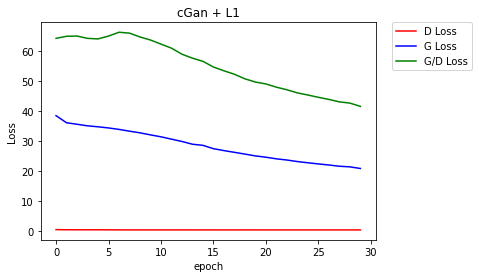

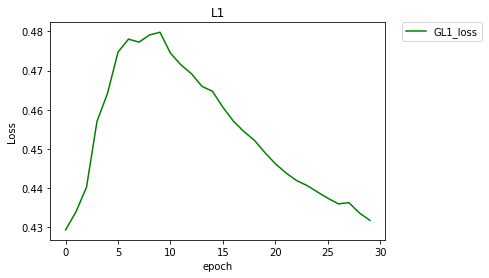

In [21]:
# Plot the loss
##########--WRITE YOUR CODE HERE--##########
G_D_loss = []
for i in range(len(G_loss)):
  G_D_loss.append(G_loss[i]/D_loss[i])

plt.plot(D_loss , 'r', label= 'D Loss')
plt.plot(G_loss , 'b', label= 'G Loss')
plt.plot(G_D_loss , 'g', label= 'G/D Loss')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('cGan + L1')
plt.show()

plt.plot(GL1_loss , 'g', label= 'GL1_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('L1')

plt.show()
##########-------END OF CODE-------##########

- First Graph : the blue curve represents the Generator Loss and The blue curve represents the Discriminator Loss.

- Second Graph : the blue curve represents the Generator Loss.

### Part 5 Evaluation
---

Compared to a classification problem, evaluating an image translation model could be tricky because we don't always have the ground-truth available. There are several different ways to compare the performance of different GAN models:

1. Visualize the generated images of different GAN models. 

2. Compute a distance, such as **Frechet Inception Distance** (**FID**, the smaller the better, [paper](https://arxiv.org/abs/1706.08500)), between the generated images and the real images, or compute the Inception Score (**IS**, the higher the better, [paper](https://arxiv.org/pdf/1606.03498.pdf)) for the generated images. We strongly encourage you to read these papers.

3. Using generated images for downstream tasks, such as classification, segmentation, etc. and computing the task accuracy.

Now it's your turn to evaluate the models you trained. 

**{5 points}** We'll first visualize `4` test samples and plot them as in Figure 4 in the pix2pix paper, to get some qualitative results. You can select any interesting samples from the **test set**.

**{5 points}** Then let's do some quantitative analysis. Adapt this **Inception Score** ([ref](https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py)) implementation, and report the mean score of each model on the test set. Again, you are encouraged to train your models longer.

Order of images = 
Input /// Groud truth /// L1 /// L1+cGAN


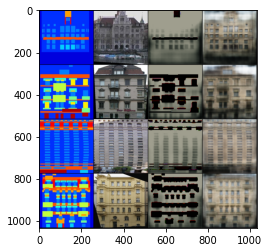

In [22]:
# Visualization
# Please read Figure 4 in the pix2pix paper first

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision
test_loader = DataLoader(dataset("test"), 1, shuffle=True)
imgs = []
for j, (a, b) in enumerate(test_loader):
    a, b = a.to(device), b.to(device)
    with torch.no_grad():
        fake_b, fake_b_l1 = netG(a), netGL1(a)
    imgs += [a[0], b[0], fake_b_l1[0],fake_b[0]]
    if j == 3:
        break
imgs = torch.stack(imgs).detach().cpu()
save_image(imgs, "imgs.png", nrow=4, normalize=True)


print('Order of images = \nInput /// Groud truth /// L1 /// L1+cGAN')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('imgs.png')
imgplot = plt.imshow(img)

plt.show()

In [23]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def inception_score(images, splits=10):
    N = len(images)
    batch_size = 1
    assert batch_size > 0
    assert N > batch_size
    dataloader = torch.utils.data.DataLoader(images, batch_size=batch_size)
    def get_pred(x):
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()
    preds = np.zeros((N, 1000))
    for i, batch in enumerate(dataloader, 0):
        batch = batch[0].type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)
    split_scores = []
    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    return np.mean(split_scores)

from torch.autograd import Variable
test_pred, test_pred_l1, ctr = [], [], 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = DataLoader(dataset("test"), 1, shuffle=True)
for j, (a, b) in enumerate(test_loader):
    a, b = a.to(device), b.to(device)
    with torch.no_grad():
        fake_b, fake_b_l1 = netG(a), netGL1(a)
    test_pred.append(fake_b)
    test_pred_l1.append(fake_b_l1)

inception_s = inception_score(test_pred)
inception_s_l1 = inception_score(test_pred_l1)
from IPython.display import HTML, display
import tabulate
table = [["Loss","Inception Score"],
         ["L1 + cGAN", f"{inception_s:.4f}"],
         ["L1", f"{inception_s_l1:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

<ipython-input-23-fbb4335c7eea>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


Loss,Inception Score
L1 + cGAN,2.1415
L1,4.0163


### Part 6 Understanding pix2pix
---
#### {5 points}Problem 1  
What image sizes can Pix2pix train with, and why can it handle different image sizes?

Hint: Explain this based on the generator and discriminator architectures.

#### {5 points}Problem 2 

Given an input image with size $256\times256\times6$ for the discriminator, write down the size of each neuron's receptive field after each layer, using the **discriminator** network architectures above:

e.g. $$Input → C64 → (?) → C128 →(?) → C256 → (?) → C512 → (?)$$

**Make sure you calculate the receptive field, not the size of the image.**

#### {5 points}Problem 3
Explain why minimizing only the L1 loss results in a blurry image. 


#### {5 points}Problem 4
Why do we use PatchGAN in Pix2pix? 


Answer:
<br>
Answer 1<br>
- Pix2Pix can train with any image sizes <br>
- Reason : because it is a fully-convolutional translation which is an advantage of the PatchGAN.
- A fixed-size patch discriminator can be applied to arbitrarily large images. - Also apply the generator convolutionally to larger images than those on which it was trained.

Answer 2 <br>

- Rec. Field of Layer L = Stride * Rec. Field for Layer L-1 + (Kernel Size - Stride)<br>
Initially r = 1<br>
  - L1, r = 2 + (4-2) = 4<br>
  - L2, r = 8 + (4-2) = 10<br>
  - L3, r = 20 + (4-2) = 22<br>
  - L4, r = 44 + (4-2) = 46<br>

Answer 3<br>
- L1 is used to incentivize and reverse a blur when it is not sure about the location of an edge, hence if we minimize L1, we get blurry image. When not sure about various color values a pixel should take on, L1 will incentivize a mean.
- L1 will be minimized by choosing the median of the conditional probability density function over possible colors.<br> 

Answer 4 <br>
- PatchGAN promotes sharp outputs.
- Great FCN-scores
- Prone to tiling artifacts
- The 70 × 70 PatchGAN alleviates these artifacts and achieves slightly better scores

### {10 points} Bonus: Spectral Normalization

Spectral normalization (**SN**, [paper](https://arxiv.org/abs/1802.05957)) is a simple and useful technique for stabilizing GAN training. Replace `batch normalization` with `spectral normalization` in both discriminator and generator, train the new model with the same L1 and cGAN loss for at least 20 epochs, then save the model to `pix2pixSN.pth`. Finally, perform the same evaluation you did in part 5 and compare the performance of all the models you trained.

Hint: use `torch.nn.utils.spectral_norm`.


In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [25]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channels):
        super(Discriminator, self).__init__()
        # C64 − C128 − C256 − C512
        self.conv1 = nn.Conv2d(n_channels*2, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv3 = torch.nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1))
        self.conv4 = torch.nn.utils.spectral_norm(nn.Conv2d(256, 512, 4, 1, 1))
        self.conv5 = torch.nn.utils.spectral_norm(nn.Conv2d(512, 1, 4, 1, 1))
        
    def forward(self, x):
        x = torch.cat([x[0], x[1]], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu((self.conv2(x)), 0.2)
        x = F.leaky_relu((self.conv3(x)), 0.2)
        x = F.leaky_relu((self.conv4(x)), 0.2)
        x_d = F.sigmoid(self.conv5(x))        
        return x_d
 
# netD = # initialize the discriminator
netD = Discriminator(3)
# feel free to do some sanity check here 

In [26]:
from torch.nn.utils import spectral_norm
class Convolution_blk(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, spectral_norm=True):
        super(Convolution_blk, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.spectral_norm = spectral_norm

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)
        return out
        
class DeConvolution_blk(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeConvolution_blk, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.spectral_norm = spectral_norm
        self.dropout = dropout

    def forward(self, x):
        out = self.deconv(self.relu(x))
        if self.dropout:
            return self.drop(out)
        else:
            return out
        
class Generator(torch.nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        # encoder = 𝐶64 − 𝐶128 − 𝐶256 − 𝐶512 − 𝐶512 − 𝐶512 − 𝐶512 − 𝐶512
        self.conv1 = Convolution_blk(input_dim, 64, activation=False, spectral_norm=True)
        self.conv2 = Convolution_blk(64, 128)
        self.conv3 = Convolution_blk(128, 256)
        self.conv4 = Convolution_blk(256, 512)
        self.conv5 = Convolution_blk(512, 512)
        self.conv6 = Convolution_blk(512, 512)
        self.conv7 = Convolution_blk(512, 512)
        self.conv8 = Convolution_blk(512, 512, spectral_norm=True)

        # decoder = 𝐶𝐷512 − 𝐶𝐷1024 − 𝐶𝐷1024 − 𝐶1024 − 𝐶1024 − 𝐶512 − 𝐶256 − 𝐶128
        self.deconv1 = DeConvolution_blk(512, 512, dropout=True)
        self.deconv2 = DeConvolution_blk(1024, 512, dropout=True)
        self.deconv3 = DeConvolution_blk(1024, 512, dropout=True)
        self.deconv4 = DeConvolution_blk(1024, 512)
        self.deconv5 = DeConvolution_blk(1024, 256)
        self.deconv6 = DeConvolution_blk(256 * 2, 128)
        self.deconv7 = DeConvolution_blk(128 * 2, 64)
        self.deconv8 = DeConvolution_blk(128, 3)

    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)

        dec1 = self.deconv1(enc8)
        dec1 = torch.cat([dec1, enc7], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc6], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc5], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc4], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc3], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc2], 1)
        dec7 = self.deconv7(dec6)
        dec7 = torch.cat([dec7, enc1], 1)
        dec8 = self.deconv8(dec7)
        out = torch.nn.Tanh()(dec8)
        return out
    
netG = Generator(3)
netGL1 = Generator(3)

In [27]:
# Define the optimizors here, make sure you give them the right parameters

og = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
od = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
ogl1 = optim.Adam(netGL1.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [28]:
from torchvision.utils import save_image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = netG.to(device)
netD = netD.to(device)
netG.train()
netD.train()

from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image

def load_image(file):
    img = PIL.Image.open(file)
    img_b = img.crop((0,0,256,256))
    img_a = img.crop((256,0,512,256))
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    return transform(img_a), transform(img_b)

class dataset(Dataset):
    def __init__(self, mode):
        self.files = glob.glob('%s/%s/*'%('facades', mode))
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        a, b = load_image(self.files[idx])
        return a, b

train_loader = DataLoader(dataset("train"), 1, shuffle=True)

def train_model(netG, netD, og, od, train_loader, epoch):
    G_loss, D_loss = [], []
    ganl = F.binary_cross_entropy_with_logits
    for i, (a, b) in enumerate(train_loader):
        a, b = a.to(device), b.to(device)
        real_image, fake_image = torch.ones((a.size(0), 1, 30, 30)).to(device) , torch.zeros((a.size(0), 1, 30, 30)).to(device)
        og.zero_grad()
        fake_image_b = netG(a)
        pred = netD((a, fake_image_b))
        loss_G = ganl(pred, real_image) + F.l1_loss(b, fake_image_b) * 100
        loss_G.backward()
        og.step()
        od.zero_grad()
        pred_real_image, pred_fake_image= netD((a, b)), netD((a, fake_image_b.detach()))
        loss_real_image, loss_fake_image = ganl(pred_real_image, real_image), ganl(pred_fake_image, fake_image)
        loss_D = (loss_real_image + loss_fake_image) * 0.5
        loss_D.backward()
        od.step()
        G_loss.append(loss_G.item())
        D_loss.append(loss_D.item())
        if (i+1) % 10 == 0:
            g_mean, d_mean = np.mean(G_loss[-10:]), np.mean(D_loss[-10:])
            print("\rEpoch %d /// Processed %d/%d /// G loss: %f /// D loss = %f" %
                    (epoch, i, len(train_loader), g_mean, d_mean))
    return np.mean(G_loss), np.mean(D_loss)

epochs = 20
G_losses = []
D_losses =[]
for epoch in range(epochs):
        G_loss, D_loss = train_model(netG, netD, og, od, train_loader, epoch)
        print('\nG Loss = %.4f /// D Loss = %.4f /// G/D Loss = %.4f\n'%(G_loss, D_loss, G_loss/D_loss))
        G_losses.append(G_loss)
        D_losses.append(D_loss)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 /// Processed 9/400 /// G loss: 47.870638 /// D loss = 0.664460
Epoch 0 /// Processed 19/400 /// G loss: 45.047828 /// D loss = 0.739196
Epoch 0 /// Processed 29/400 /// G loss: 37.037113 /// D loss = 0.662729
Epoch 0 /// Processed 39/400 /// G loss: 35.645979 /// D loss = 0.640723
Epoch 0 /// Processed 49/400 /// G loss: 39.569036 /// D loss = 0.595714
Epoch 0 /// Processed 59/400 /// G loss: 37.706655 /// D loss = 0.607537
Epoch 0 /// Processed 69/400 /// G loss: 41.701281 /// D loss = 0.591175
Epoch 0 /// Processed 79/400 /// G loss: 40.799878 /// D loss = 0.559293
Epoch 0 /// Processed 89/400 /// G loss: 43.835752 /// D loss = 0.564165
Epoch 0 /// Processed 99/400 /// G loss: 35.282670 /// D loss = 0.554559
Epoch 0 /// Processed 109/400 /// G loss: 46.158089 /// D loss = 0.551389
Epoch 0 /// Processed 119/400 /// G loss: 39.023726 /// D loss = 0.519133
Epoch 0 /// Processed 129/400 /// G loss: 41.402744 /// D loss = 0.520325
Epoch 0 /// Processed 139/400 /// G loss: 38.9665

In [29]:
netGL1 = netGL1.to(device)
netGL1.train()

def train_model(netGL1, og, train_loader, epoch):

    GL1_loss = []

    for i, (a, b) in enumerate(train_loader):
        a, b = a.to(device), b.to(device)
        real , fake= torch.ones((a.size(0), 1, 30, 30)).to(device), torch.zeros((a.size(0), 1, 30, 30)).to(device)
        og.zero_grad()
        fake_b = netGL1(a)
        loss_G = F.l1_loss(b, fake_b)
        loss_G.backward()
        ogl1.step()
        GL1_loss.append(loss_G.item())

        if (i+1) % 10 == 0:
            g_mean = np.mean(GL1_loss[-10:])
            print("\rEpoch %d | Processed %d/%d | GL1 loss: %f" %
                    (epoch, i, len(train_loader), g_mean))

        iters = epoch * len(train_loader) + i

    return np.mean(GL1_loss)

epoch_l1 = 20
GL1_losses = []
for epoch in range(epoch_l1):
        GL1_loss = train_model(netGL1, og, train_loader, epoch)
        print('\nGL1_loss: %.4f \n'%(GL1_loss))
        GL1_losses.append(GL1_loss)

Epoch 0 | Processed 9/400 | GL1 loss: 0.460425
Epoch 0 | Processed 19/400 | GL1 loss: 0.362334
Epoch 0 | Processed 29/400 | GL1 loss: 0.387998
Epoch 0 | Processed 39/400 | GL1 loss: 0.461121
Epoch 0 | Processed 49/400 | GL1 loss: 0.417622
Epoch 0 | Processed 59/400 | GL1 loss: 0.385800
Epoch 0 | Processed 69/400 | GL1 loss: 0.403663
Epoch 0 | Processed 79/400 | GL1 loss: 0.364310
Epoch 0 | Processed 89/400 | GL1 loss: 0.385084
Epoch 0 | Processed 99/400 | GL1 loss: 0.415705
Epoch 0 | Processed 109/400 | GL1 loss: 0.421404
Epoch 0 | Processed 119/400 | GL1 loss: 0.386139
Epoch 0 | Processed 129/400 | GL1 loss: 0.401128
Epoch 0 | Processed 139/400 | GL1 loss: 0.359501
Epoch 0 | Processed 149/400 | GL1 loss: 0.409034
Epoch 0 | Processed 159/400 | GL1 loss: 0.381579
Epoch 0 | Processed 169/400 | GL1 loss: 0.400115
Epoch 0 | Processed 179/400 | GL1 loss: 0.380155
Epoch 0 | Processed 189/400 | GL1 loss: 0.383857
Epoch 0 | Processed 199/400 | GL1 loss: 0.374350
Epoch 0 | Processed 209/400 | G

In [ ]:
# codes for saving models, feel free to change them

torch.save({
    'G': netG.state_dict(),
    'D': netD.state_dict(),
    'epoch': epochs,
    'loss_G': G_losses,
    'loss_D': D_losses,
    }, 'pix2pix_spectral.pth')

torch.save({
    'G': netGL1.state_dict(),
    'epoch': epoch_l1,
    'loss': GL1_losses,
    }, 'pix2pixL1_spectral.pth')

In [35]:
# codes for restoring models, feel free to change them

path = "pix2pix_spectral.pth"
checkpoint = torch.load(path)
netG.load_state_dict(checkpoint['G'])
netD.load_state_dict(checkpoint['D'])
epoch = checkpoint['epoch']
G_loss = checkpoint['loss_G']
D_loss = checkpoint['loss_D']

path = "pix2pixL1_spectral.pth"
checkpoint = torch.load(path)
netGL1.load_state_dict(checkpoint['G'])
epoch_l1 = checkpoint['epoch']
GL1_loss = checkpoint['loss']

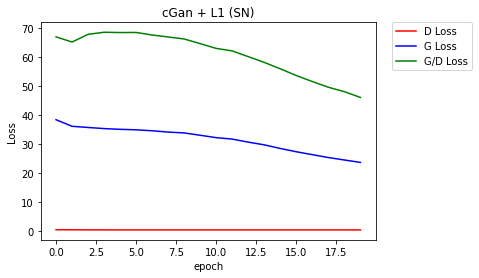

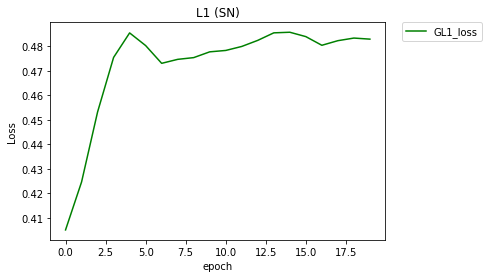

In [32]:
# Plot the loss
G_D_loss = []
for i in range(len(G_loss)):
  G_D_loss.append(G_loss[i]/D_loss[i])

plt.plot(D_loss , 'r', label= 'D Loss')
plt.plot(G_loss , 'b', label= 'G Loss')
plt.plot(G_D_loss , 'g', label= 'G/D Loss')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('cGan + L1 (SN)')
plt.show()

plt.plot(GL1_loss , 'g', label= 'GL1_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('L1 (SN)')

plt.show()

   The order of images is: 
Input | Groud truth | L1 | L1+cGAN


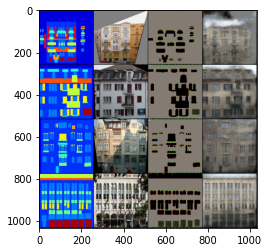

In [33]:
# Visualization
# Please read Figure 4 in the pix2pix paper first

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision
test_loader = DataLoader(dataset("test"), 1, shuffle=True)
imgs = []
for j, (a, b) in enumerate(test_loader):
    a, b = a.to(device), b.to(device)
    with torch.no_grad():
        fake_b, fake_b_l1 = netG(a), netGL1(a)
    imgs += [a[0], b[0], fake_b_l1[0],fake_b[0]]
    if j == 3:
        break
imgs = torch.stack(imgs).detach().cpu()
save_image(imgs, "imgs.png", nrow=4, normalize=True)


print('   The order of images is: \nInput | Groud truth | L1 | L1+cGAN')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('imgs.png')
imgplot = plt.imshow(img)

plt.show()

In [34]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def inception_score(images, splits=10):
    N = len(images)
    #print(N)
    batch_size = 1
    assert batch_size > 0
    assert N > batch_size

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(images, batch_size=batch_size)

    def get_pred(x):
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch[0].type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores)


# Get the translation on test set

from torch.autograd import Variable
test_pred = []
test_pred_l1 = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ctr = 0

test_loader = DataLoader(dataset("test"), 1, shuffle=True)
# imgs = []
# imgs_l1 = []
for j, (a, b) in enumerate(test_loader):
    a = a.to(device)
    b = b.to(device)
    with torch.no_grad():
        fake_b = netG(a)
        fake_b_l1 = netGL1(a)
    test_pred.append(fake_b)
    test_pred_l1.append(fake_b_l1)


inception_s = inception_score(test_pred)
inception_s_l1 = inception_score(test_pred_l1)
from IPython.display import HTML, display
import tabulate
table = [["Loss","Inception Score"],
         ["L1 + cGAN", f"{inception_s:.4f}"],
         ["L1", f"{inception_s_l1:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

<ipython-input-34-b60e0a25a605>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


Loss,Inception Score
L1 + cGAN,2.1415
L1,3.8692
